In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import gsw
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtik, ytik):
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtik, crs=ccrs.PlateCarree())
    ax.set_yticks(ytik, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



def Plot_Contours(data_set, reg, minl, maxl, nlevs, nlines, tstep=None, cmap=None):
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtik = np.linspace(lon1, lon2, num=5)
    ytik = np.linspace(lat1, lat2, num=4)

    x_n, y_n = Grid(data_set)

    projection = ccrs.PlateCarree(360)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    if not cmap:
        cmap = 'magma_r'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtik, ytik)
    
    if tstep==None:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst, levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)
    else:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst[tstep], levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[tstep,0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)

    #fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))
    #plt.close(fig)
    plt.show()

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

## Now working in any point in year 2005


dir_1 = '../../data_ARMOR/'
dir_2 = '../Vertical-prof/'
file1 = 'ARMOR_*.nc'
file2 = 'ARMOR_2005.nc'

just_1 = xr.open_dataset(dir_1 + file2)


In [5]:
reg = 'gul'
## File format :: t, lat, lon
gulf = Crops(reg, just_1)

In [6]:
mean = gulf.mean(dim='time', skipna=True)
stdv = gulf.std(dim='time', skipna=True)

mn_mld = mean.mlotst.min(skipna=True).values
mx_mld = mean.mlotst.max(skipna=True).values

mn_mlds = stdv.mlotst.min(skipna=True).values
mx_mlds = stdv.mlotst.max(skipna=True).values

print(mn_mld, mx_mld, mn_mlds, mx_mlds)

/venv/py3-phyocean/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


13.964481 116.809586 0.0 359.77194


## Mean + std :: MLD

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


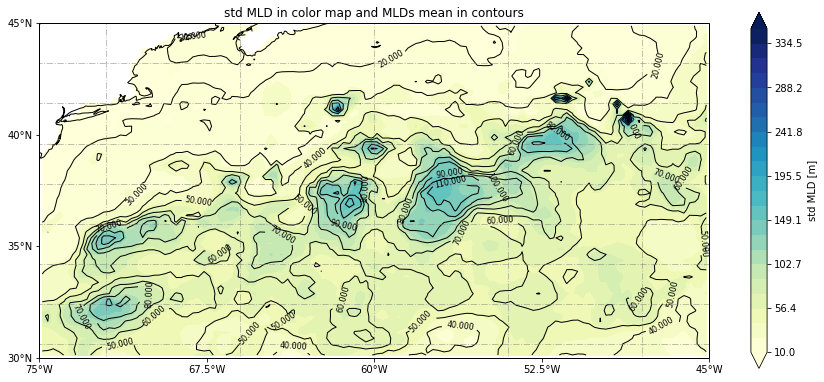

In [7]:
lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

#vel = np.sqrt( stdv.ugo[0]*stdv.ugo[0] + stdv.vgo[0]*stdv.vgo[0] )

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(15,10))    

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, stdv.mlotst, levels=np.linspace(10., 350., 23),
                             cmap='YlGnBu', extend='both')
contr2 = ax.contour(x_n, y_n, mean.mlotst, 10, linewidths=1, colors='k')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.655, orientation='vertical',
                    label='std MLD [m]', extend='both')  

cbar.set_clim(vmin=0., vmax=300.)
ax.clabel(contr2, fontsize=8, inline=4)
ax.set_title('std MLD in color map and MLD''s mean in contours')


plt.show()

## Mean + std :: geopotential heigth

In [8]:
mini = stdv.zo[0].min(skipna=True).values
maxi = stdv.zo[0].max(skipna=True).values


print(mini, maxi)

0.020139787 0.48537868


/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


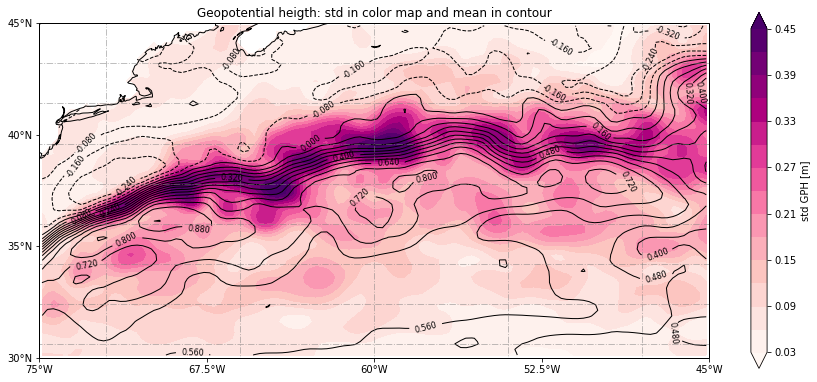

In [9]:
lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

#vel = np.sqrt( stdv.ugo[0]*stdv.ugo[0] + stdv.vgo[0]*stdv.vgo[0] )

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(15,10))    

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, stdv.zo[0], levels=np.linspace(0.03, 0.45, 15),
                             cmap='RdPu', extend='both')
contr2 = ax.contour(x_n, y_n, mean.zo[0], 20, linewidths=1, colors='k')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.655, orientation='vertical',
                    label='std GPH [m]', extend='both')  


ax.clabel(contr2, fontsize=8, inline=True)
ax.set_title('Geopotential heigth: std in color map and mean in contour')

cbar.set_clim(-0.1, 0.1)
plt.show()

## Color map: std MLD and contour std GPH

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


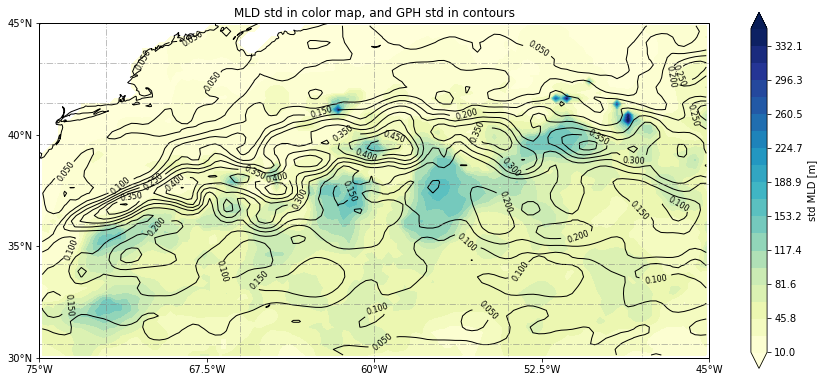

In [10]:
lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

#vel = np.sqrt( stdv.ugo[0]*stdv.ugo[0] + stdv.vgo[0]*stdv.vgo[0] )

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(15,10))    

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, stdv.mlotst, levels=np.linspace(10., 350., 20),
                             cmap='YlGnBu', extend='both')
contr2 = ax.contour(x_n, y_n, stdv.zo[0], 10, linewidths=1, colors='k')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.655, orientation='vertical',
                    label='std MLD [m]', extend='both')  


ax.clabel(contr2, fontsize=8, inline=True)
ax.set_title('MLD std in color map, and GPH std in contours')

cbar.set_clim(-0.5, 0.5)
plt.show()

Comparing MLD std and temperature std:: bad idea, apparently

In [ ]:
gulf.depth

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


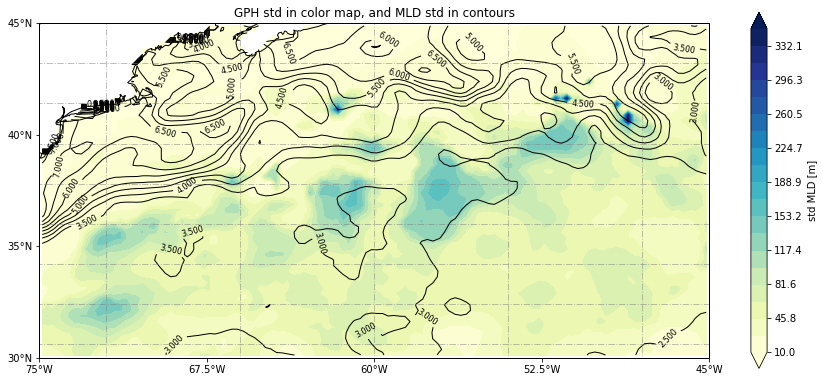

In [11]:
lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

#vel = np.sqrt( stdv.ugo[0]*stdv.ugo[0] + stdv.vgo[0]*stdv.vgo[0] )

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(15,10))    

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, stdv.mlotst, levels=np.linspace(10., 350., 20),
                             cmap='YlGnBu', extend='both')
contr2 = ax.contour(x_n, y_n, stdv.to[0], 15, linewidths=1, colors='k')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.655, orientation='vertical',
                    label='std MLD [m]', extend='both')  


ax.clabel(contr2, fontsize=8, inline=True)
ax.set_title('GPH std in color map, and MLD std in contours')

cbar.set_clim(-0.5, 0.5)
plt.show()

I can also compare p2p of MLD with std of gph:: Whats the meaning of this? It isnt p2p value a similar valoration like std?


In [12]:
amp = gulf.max(dim='time') - gulf.min(dim='time')

min_amp = amp.mlotst.min(skipna=True).values
max_amp = amp.mlotst.max(skipna=True).values

print(min_amp, max_amp)

/venv/py3-phyocean/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


0.0 2592.3


/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


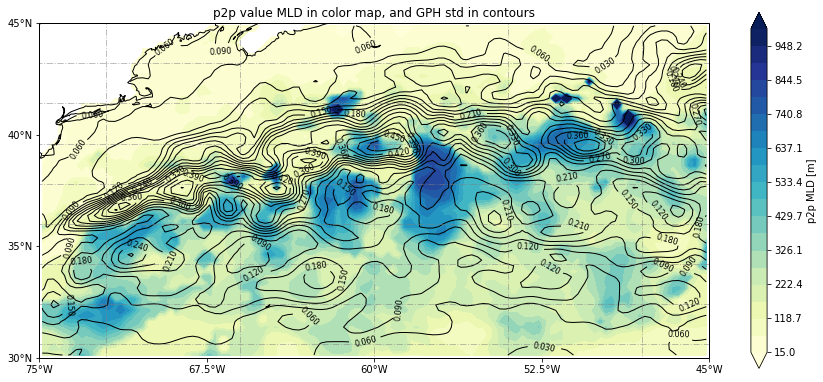

In [13]:
lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
xtik = np.linspace(lon1, lon2, num=5)
ytik = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gulf)

projection = ccrs.PlateCarree(360)
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

#vel = np.sqrt( stdv.ugo[0]*stdv.ugo[0] + stdv.vgo[0]*stdv.vgo[0] )

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(15,10))    

Map(ax, region, xtik, ytik)

contr1 = ax.contourf(x_n, y_n, amp.mlotst, levels=np.linspace(15., 1000., 20),
                             cmap='YlGnBu', extend='both')
contr2 = ax.contour(x_n, y_n, stdv.zo[0], 15, linewidths=1, colors='k')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.655, orientation='vertical',
                    label='p2p MLD [m]', extend='both')  


ax.clabel(contr2, fontsize=8, inline=True)
ax.set_title('p2p value MLD in color map, and GPH std in contours')

cbar.set_clim(-0.5, 0.5)
plt.show()